A QFT band pass filter with state vector simulator

Python code running Qiskit to perform a rough and ready bandpass filter using a quantum fourier transform (QFT).

First create some test data of two sine waves Y = sin(x), then convert the data into state vectors, perform a QFT,
show the frequency components, perform a rough band pass filter and convert back to a real signal.

The QFT routines are from https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html """

In [18]:
#Initialise libraries
import cmath 
import numpy as np
from numpy import pi
import matplotlib.pyplot as plot
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit

In [4]:
#From https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html 
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
'''qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')'''

"qc = QuantumCircuit(4)\nqft_rotations(qc,4)\nqc.draw('mpl')"

In [5]:
#From https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html 
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
'''qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')'''

"qc = QuantumCircuit(4)\nqft(qc,4)\nqc.draw('mpl')"

In [6]:
#From https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html 
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit #.decompose() # .decompose() allows us to see the individual gates

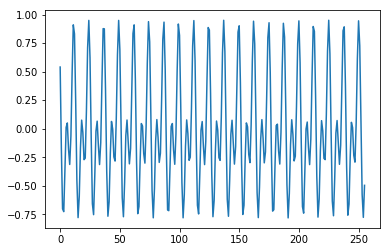

In [14]:
######################### start here ######################
numpts = 8 #number of data points = number of qubits
#initialise variables
zl=[] #list for z values
#create test signal of 2 sine waves with different frequencies
w1=1;p1=1
w2=0.5;p2=1
for t in range(0,2**numpts):
    x1 = np.cos(w1*t + p1)
    x2 = np.cos(w2*t + p2)
    z = (x1 + x2)/2
    zl.append(z)
#print(zl)
plot.plot(zl)
plot.show()

C:\Users\paulgriffin.SMUSTF\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


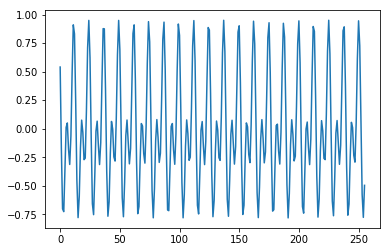

In [15]:
#create state vectors based on the signal data
state = qi.Statevector(zl)
#print(state.data)
plot.plot(state.data)
plot.show() #the signal has mapped onto the real part of the statevectors

In [21]:
#create the QFT circuit
qc = QuantumCircuit(numpts)
qft(qc,numpts)
#qc.draw('mpl')

C:\Users\paulgriffin.SMUSTF\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


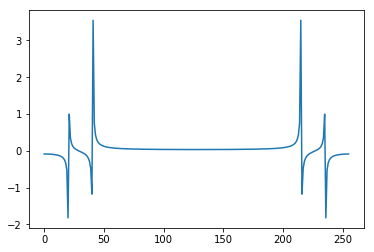

In [22]:
#run the QFT circuit on the wave state
stateqft = state.evolve(qc)
plot.plot(stateqft.data)
plot.show() # observe the 2 frequency peaks, mirrored in fourier space

C:\Users\paulgriffin.SMUSTF\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


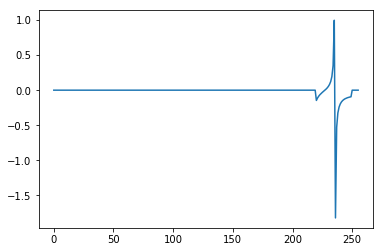

In [24]:
#Remove one of the frequncies with a simple box function zeroing the unwanted frequncies
def bandPass(minf,maxf):
    pts=maxf-minf
    fft_chop = stateqft.data.copy()
    fft_chop[0:minf]=0
    fft_chop[maxf:2**numpts]=0    
    return fft_chop

qft_chop = bandPass(220,250)
fft_absc = np.abs(qft_chop)

plot.plot(qft_chop)#, freq, sp.imag)
plot.show() #observe the frequncy removal 

In [26]:
#Store the state for the modified fourier data
stateChop = qi.Statevector(qft_chop)

In [27]:
# Create an inerse QFT from the original QFT circuit
invqft_circ = qc.inverse()
#invqft_circ.draw('mpl')

C:\Users\paulgriffin.SMUSTF\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


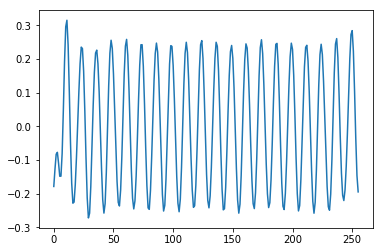

In [28]:
#Run the inverse QFT on the modified state to get back a modified signal
stateinvqft = stateChop.evolve(invqft_circ)
plot.plot(stateinvqft.data)
plot.show() #Observe the one sine wave has been removed. The complex components can be easily removed.